# CO₂/N₂ Adsorption & IAST Analysis Notebook

In [4]:

# Part 0 — Environment & utilities
import os
import re
from typing import Dict, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
DATA_DIR = os.getcwd()

try:
    import pyiast
    from pyiast import ModelIsotherm, iast
    HAVE_PYIAST = True
except Exception as e:
    HAVE_PYIAST = False
    print("pyiast not available. Install with: pip install pyiast")
    print("IAST/model-fitting cells will skip gracefully.")

# Matplotlib defaults (no specific colors set)
plt.rcParams["figure.figsize"] = (6.5, 4.2)
plt.rcParams["axes.grid"] = True

import os
DATA_DIR = os.getcwd()

def parse_filename(fname: str) -> Dict[str, Optional[str]]:
    """
    Robust parser for file names like:
      - UTSA-20-P-CO2.csv
      - ZIF-8-H-N2.csv
      - PA-UTSA-20.csv
      - Mg-P-CO2.csv  (Mg = Mg-MOF-74)
      - PA-Mg.csv

    Returns dict with keys:
      kind ('PA' or 'ISO'), material, mode ('P' or 'H'), gas ('CO2' or 'N2'), raw
    """
    base = os.path.splitext(os.path.basename(fname))[0]
    parts = base.split("-")
    d = {"raw": base, "kind": "ISO", "material": None, "mode": None, "gas": None}
    # PA prefix
    if base.startswith("PA-"):
        d["kind"] = "PA"
        d["material"] = base[3:]
        return d

    # Heuristics: last token often gas; one before often mode (P/H)
    if parts[-1] in ("CO2", "N2"):
        d["gas"] = parts[-1]
        parts = parts[:-1]
    if parts and parts[-1] in ("P", "H"):
        d["mode"] = parts[-1]
        parts = parts[:-1]

    # Remaining parts compose the material name
    material = "-".join(parts)
    if material == "Mg":
        material = "Mg-MOF-74"
    d["material"] = material if material else None
    return d

def read_isotherm_csv(path: str) -> pd.DataFrame:
    """
    Robust isotherm reader.
    - Sniffs delimiter (',' or ';'), falls back appropriately.
    - Accepts European decimals (',' -> '.').
    - Accepts many header variants and headerless two-column files.
    - Returns columns: ['P','q'] and optional ['T'].
    """
    import pandas as pd, numpy as np, re

    # 1) Try to sniff delimiter; fall back to common ones
    try:
        df = pd.read_csv(path, sep=None, engine="python")
    except Exception:
        df = None
    if df is None or df.shape[1] == 1:
        for sep in [",", ";", r"\s+"]:
            try:
                df = pd.read_csv(path, sep=sep, engine="python")
                break
            except Exception:
                df = None
        if df is None:
            return pd.DataFrame(columns=["P","q","T"])

    # 2) Convert comma decimals if present
    for c in df.columns:
        if df[c].dtype == object:
            try:
                df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", "."), errors="ignore")
            except Exception:
                pass

    # 3) Normalize headers: strip spaces/brackets/()// and lowercase
    norm = {}
    for c in df.columns:
        cl = re.sub(r"[\s\[\]\(\)/]", "", str(c)).lower()
        norm[c] = cl
    df = df.rename(columns=norm)

    # 4) If headerless (pure numeric) guess first two columns
    if df.shape[1] >= 2 and not any(k in df.columns for k in ["p","pressure","bar","pbar","pkpa","ppa"]):
        # leave as is; we will pick first two numeric columns below if needed
        pass

    # 5) Find pressure and loading columns
    # Pressure candidates
    P_candidates = [c for c in df.columns if c.startswith("p") or "press" in c or c in ["bar","pbar","pkpa","ppa"]]
    # Loading candidates
    q_candidates = [c for c in df.columns if any(k in c for k in
                     ["q","load","uptake","mmolg","mmol/g","adsorption","amount","nmmolg","nmmolgg"])]

    # Fallback: if nothing matched, try "first two numeric-looking columns"
    if not P_candidates or not q_candidates:
        numeric_cols = [c for c in df.columns if pd.to_numeric(df[c], errors="coerce").notna().sum() > 0]
        if len(numeric_cols) >= 2:
            P_candidates = P_candidates or [numeric_cols[0]]
            q_candidates = q_candidates or [numeric_cols[1]]

    if not P_candidates or not q_candidates:
        return pd.DataFrame(columns=["P","q","T"])

    Pcol, qcol = P_candidates[0], q_candidates[0]
    out = pd.DataFrame({"P": pd.to_numeric(df[Pcol], errors="coerce"),
                        "q": pd.to_numeric(df[qcol], errors="coerce")})

    # Optional T
    T_candidates = [c for c in df.columns if c in ["t","temp","temperature","temperaturek","temperaturec"] or "temp" in c]
    if T_candidates:
        out["T"] = pd.to_numeric(df[T_candidates[0]], errors="coerce")

    return out.dropna(subset=["P","q"]).reset_index(drop=True)

def low_pressure_henry_coefficient(df: pd.DataFrame, pmax: float = 0.05) -> Optional[float]:
    """
    Estimate Henry's coefficient from the slope dq/dP near P=0.
    Uses linear fit for data with P <= pmax (bar). If units are not bar, adjust upstream.
    Returns H in units of q/P (e.g., mmol g^-1 bar^-1).
    """
    if "P" not in df.columns or "q" not in df.columns:
        return None
    sub = df[df["P"] <= pmax].copy()
    if len(sub) < 3:
        # If too few points under pmax, take the first 5% of points
        n = max(3, int(0.05 * len(df)))
        sub = df.head(n).copy()
    if len(sub) < 3:
        return None
    # Linear fit q ~ H*P
    P = sub["P"].values
    q = sub["q"].values
    H, _, _, _ = np.linalg.lstsq(P.reshape(-1,1), q, rcond=None)
    return float(H[0])

def fit_isotherm_model(df: pd.DataFrame, model: str = "Langmuir"):
    """
    Fit a simple pyiast ModelIsotherm to the data.
    Supported models: 'Langmuir', 'LangmuirFreundlich', 'DualSiteLangmuir'
    Returns a fitted ModelIsotherm or None if pyiast unavailable.
    """
    if not HAVE_PYIAST:
        return None
    model_map = {
        "Langmuir": "Langmuir",
        "LangmuirFreundlich": "Langmuir-Freundlich",
        "DualSiteLangmuir": "DSLangmuir"
    }
    mname = model_map.get(model, "Langmuir")
    try:
        iso = ModelIsotherm(df, loading_key="q", pressure_key="P", model=mname)
        return iso
    except Exception as e:
        print("Model fit failed:", e)
        return None

def iast_selectivity(iso1, iso2, y1: float, y2: float, P_total: float) -> Optional[float]:
    """
    Compute IAST selectivity S_(1/2) = (x1/x2) / (y1/y2)
    where component 1 is e.g. CO2, component 2 is N2.
    Requires fitted ModelIsotherm objects (pyiast).
    """
    if not HAVE_PYIAST:
        return None
    try:
        res = iast([y1, y2], [iso1, iso2], P=P_total)
        x1, x2 = res
        S = (x1/x2) / (y1/y2)
        return float(S)
    except Exception as e:
        print("IAST failed:", e)
        return None

def detect_unit_from_column_name(colname: str) -> Optional[str]:
    """
    Try to detect pressure unit from column name.
    Returns 'bar', 'kPa', 'Pa' or None.
    """
    cl = colname.lower()
    if "bar" in cl:
        return "bar"
    if "kpa" in cl:
        return "kPa"
    if "pa" in cl:
        return "Pa"
    return None

def to_bar(P: np.ndarray, unit: Optional[str]) -> np.ndarray:
    if unit == "bar":
        return P
    if unit == "kPa":
        return P / 100.0
    if unit == "Pa":
        return P / 1.0e5
    return P  # assume bar if unknown


In [5]:

# Part 1 — Load & catalog datasets
import glob

paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
catalog = []
dfs = {}

for p in paths:
    meta = parse_filename(p)
    try:
        df_raw = pd.read_csv(p)
        # detect pressure unit from column names (best effort)
        pcol = None
        for c in df_raw.columns:
            if c.lower().startswith("p") or "press" in c.lower():
                pcol = c
                break
        unit = detect_unit_from_column_name(pcol) if pcol else None
        std = read_isotherm_csv(p)
        if "P" in std.columns:
            std["P"] = to_bar(std["P"].values, unit)
        dfs[os.path.basename(p)] = std
        catalog.append({**meta, "file": os.path.basename(p), "npoints": len(std)})
    except Exception as e:
        catalog.append({**meta, "file": os.path.basename(p), "npoints": 0, "error": str(e)})

catalog_df = pd.DataFrame(catalog).sort_values(["material","mode","gas","file"], na_position="last")
catalog_df.reset_index(drop=True, inplace=True)
catalog_df


C:\Users\noah2\AppData\Local\Temp\ipykernel_13340\229083486.py:93: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", "."), errors="ignore")
C:\Users\noah2\AppData\Local\Temp\ipykernel_13340\229083486.py:93: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", "."), errors="ignore")
C:\Users\noah2\AppData\Local\Temp\ipykernel_13340\229083486.py:93: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", "."), errors="ignore")
C:\Users\noah2\AppData\Local\Temp\ipykernel_13340\229083486.py:93: Fut

,raw,kind,material,mode,gas,file,npoints
0,PA-Mg,PA,Mg,None,None,PA-Mg.csv,0
1,Mg-H-CO2,ISO,Mg-MOF-74,H,CO2,Mg-H-CO2.csv,0
2,Mg-H-N2,ISO,Mg-MOF-74,H,N2,Mg-H-N2.csv,0
3,Mg-P-CO2,ISO,Mg-MOF-74,P,CO2,Mg-P-CO2.csv,0
4,Mg-P-N2,ISO,Mg-MOF-74,P,N2,Mg-P-N2.csv,0
5,NOTT-H-CO2,ISO,NOTT,H,CO2,NOTT-H-CO2.csv,0
6,NOTT-H-N2,ISO,NOTT,H,N2,NOTT-H-N2.csv,0
7,NOTT-P-CO2,ISO,NOTT,P,CO2,NOTT-P-CO2.csv,0
8,NOTT-P-N2,ISO,NOTT,P,N2,NOTT-P-N2.csv,0
9,PA-NOTT-300,PA,NOTT-300,None,None,PA-NOTT-300.csv,0


In [16]:

# Part 3 — Henry's coefficients (from low-P slope) and comparison to '-H-' files if present
henry_rows = []
for _, r in catalog_df[catalog_df["kind"]=="ISO"].iterrows():
    key = r["file"]
    df = dfs.get(key, pd.DataFrame())
    if len(df)>0 and "P" in df.columns and "q" in df.columns:
        H = low_pressure_henry_coefficient(df, pmax=0.05)  # assumes P in bar
        henry_rows.append({"file": key, "material": r["material"], "gas": r["gas"], "H_est_slope": H})

henry_df = pd.DataFrame(henry_rows).sort_values(["material","gas","file"]).reset_index(drop=True)
henry_df


KeyError: 'material'

In [18]:
import pandas as pd
import numpy as np
import re
import ast

def read_isotherm_csv(path: str) -> pd.DataFrame:
    """
    Robust isotherm reader that handles both standard CSV format and dictionary format.
    
    Dictionary format example:
    isotherm,"{'pressure': [0.2, 0.57, ...], 'loading_absolute_average': [0.80, 2.42, ...]}"
    
    Standard CSV format:
    P,q
    0.2,0.807
    0.57,2.426
    
    Returns DataFrame with columns: ['P','q'] and optional ['T'].
    """
    
    # First, try to detect if it's a dictionary format
    try:
        with open(path, 'r') as f:
            first_line = f.readline().strip()
            
        # Check if it contains a dictionary structure
        if "{'pressure':" in first_line or '{"pressure":' in first_line:
            # Extract the dictionary part
            if ',"' in first_line:
                dict_str = first_line.split(',"', 1)[1].rstrip('"')
            elif ',"' in first_line:
                dict_str = first_line.split(",", 1)[1].strip().strip('"')
            else:
                dict_str = first_line
            
            # Convert string to dictionary
            data_dict = ast.literal_eval(dict_str)
            
            # Extract pressure and loading data
            P = data_dict.get('pressure', [])
            q = data_dict.get('loading_absolute_average', [])
            
            # Create DataFrame
            df = pd.DataFrame({
                'P': P,
                'q': q
            })
            
            # Convert loading from mol/kg to mmol/g if needed
            loading_unit = data_dict.get('loading_absolute_unit', 'mol/kg')
            if loading_unit == 'mol/kg':
                df['q'] = df['q']  # mol/kg = mmol/g, so no conversion needed
            
            # Convert pressure to bar if needed
            pressure_unit = data_dict.get('pressure_unit', 'bar')
            if pressure_unit == 'kPa':
                df['P'] = df['P'] / 100.0
            elif pressure_unit == 'Pa':
                df['P'] = df['P'] / 1.0e5
            
            # Add temperature if available
            if 'temperature' in data_dict:
                df['T'] = data_dict['temperature']
            
            return df.dropna(subset=['P', 'q']).reset_index(drop=True)
            
    except Exception as e:
        # If dictionary parsing fails, fall back to standard CSV parsing
        pass
    
    # Standard CSV parsing (original code)
    try:
        df = pd.read_csv(path, sep=None, engine="python")
    except Exception:
        df = None
    
    if df is None or df.shape[1] == 1:
        for sep in [",", ";", r"\s+"]:
            try:
                df = pd.read_csv(path, sep=sep, engine="python")
                break
            except Exception:
                df = None
        if df is None:
            return pd.DataFrame(columns=["P","q","T"])

    # Convert comma decimals if present
    for c in df.columns:
        if df[c].dtype == object:
            try:
                df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", "."), errors="ignore")
            except Exception:
                pass

    # Normalize headers
    norm = {}
    for c in df.columns:
        cl = re.sub(r"[\s\[\]\(\)/]", "", str(c)).lower()
        norm[c] = cl
    df = df.rename(columns=norm)

    # Find pressure and loading columns
    P_candidates = [c for c in df.columns if c.startswith("p") or "press" in c or c in ["bar","pbar","pkpa","ppa"]]
    q_candidates = [c for c in df.columns if any(k in c for k in
                     ["q","load","uptake","mmolg","mmol/g","adsorption","amount","nmmolg","nmmolgg"])]

    # Fallback: first two numeric columns
    if not P_candidates or not q_candidates:
        numeric_cols = [c for c in df.columns if pd.to_numeric(df[c], errors="coerce").notna().sum() > 0]
        if len(numeric_cols) >= 2:
            P_candidates = P_candidates or [numeric_cols[0]]
            q_candidates = q_candidates or [numeric_cols[1]]

    if not P_candidates or not q_candidates:
        return pd.DataFrame(columns=["P","q","T"])

    Pcol, qcol = P_candidates[0], q_candidates[0]
    out = pd.DataFrame({"P": pd.to_numeric(df[Pcol], errors="coerce"),
                        "q": pd.to_numeric(df[qcol], errors="coerce")})

    # Optional T
    T_candidates = [c for c in df.columns if c in ["t","temp","temperature","temperaturek","temperaturec"] or "temp" in c]
    if T_candidates:
        out["T"] = pd.to_numeric(df[T_candidates[0]], errors="coerce")

    return out.dropna(subset=["P","q"]).reset_index(drop=True)


# Test the function
if __name__ == "__main__":
    # Example usage
    import os
    
    # Assuming DATA_DIR is defined
    # DATA_DIR = os.getcwd()
    
    # Example: Read a file
    # df = read_isotherm_csv(os.path.join(DATA_DIR, "UTSA-20-P-CO2.csv"))
    # print(df.head())
    
    print("Updated read_isotherm_csv function ready!")
    print("This function now handles both:")
    print("  1. Dictionary format (with 'pressure' and 'loading_absolute_average')")
    print("  2. Standard CSV format (with columns like P, q)")

Updated read_isotherm_csv function ready!
This function now handles both:
  1. Dictionary format (with 'pressure' and 'loading_absolute_average')
  2. Standard CSV format (with columns like P, q)


In [19]:
# Part 4 — Calculate CO2 Working Capacity (WC) for each structure

import pandas as pd
import numpy as np

# Process conditions from the project description
P_adsorption = 1.0  # bar (atmospheric pressure)
P_desorption = 0.2  # bar (vacuum pressure)
T = 298.15  # K (25°C)

# Flue gas composition
y_CO2 = 0.15  # 15% CO2
y_N2 = 0.85   # 85% N2

# Dictionary to store results
wc_results = {}

print("="*70)
print("CO2 WORKING CAPACITY CALCULATION")
print("="*70)
print(f"Adsorption conditions: P = {P_adsorption} bar, T = 25°C")
print(f"Desorption conditions: P = {P_desorption} bar, T = 25°C")
print(f"Flue gas composition: {y_CO2*100}% CO2, {y_N2*100}% N2")
print("="*70)

for mat in materials:
    print(f"\nProcessing material: {mat}")
    
    # Get CO2 and N2 isotherm data for this material
    co2_rows = catalog_df[(catalog_df["kind"]=="ISO") & 
                      (catalog_df["material"]==mat) & 
                      (catalog_df["gas"]=="CO2") & 
                      (catalog_df["mode"]=="P")] 
    
    n2_rows = catalog_df[(catalog_df["kind"]=="ISO") & 
                         (catalog_df["material"]==mat) & 
                         (catalog_df["gas"]=="N2") & 
                         (catalog_df["mode"]=="P")]
    
    if len(co2_rows) == 0 or len(n2_rows) == 0:
        print(f"  ⚠ Missing isotherm data for {mat}")
        continue
    
    # Get the dataframes
    co2_key = co2_rows.iloc[0]["file"]
    n2_key = n2_rows.iloc[0]["file"]
    
    df_co2 = dfs.get(co2_key, pd.DataFrame())
    df_n2 = dfs.get(n2_key, pd.DataFrame())
    
    if len(df_co2) == 0 or len(df_n2) == 0:
        print(f"  ⚠ Empty dataframes for {mat}")
        continue
    
    # Fit isotherm models for IAST calculations
    print(f"  Fitting isotherm models...")
    iso_co2 = fit_isotherm_model(df_co2, model="Langmuir")
    iso_n2 = fit_isotherm_model(df_n2, model="Langmuir")
    
    if iso_co2 is None or iso_n2 is None:
        print(f"  ⚠ Model fitting failed for {mat}")
        continue
    
    # Calculate binary loadings at adsorption conditions using IAST
    try:
        print(f"  Calculating IAST at adsorption pressure ({P_adsorption} bar)...")
        q_ads = iast([y_CO2, y_N2], [iso_co2, iso_n2], P=P_adsorption)
        q_CO2_ads = q_ads[0]  # CO2 loading at adsorption
        
        print(f"  Calculating IAST at desorption pressure ({P_desorption} bar)...")
        q_des = iast([y_CO2, y_N2], [iso_co2, iso_n2], P=P_desorption)
        q_CO2_des = q_des[0]  # CO2 loading at desorption
        
        # Calculate working capacity
        WC = q_CO2_ads - q_CO2_des
        
        wc_results[mat] = {
            'q_CO2_adsorption': q_CO2_ads,
            'q_CO2_desorption': q_CO2_des,
            'Working_Capacity': WC
        }
        
        print(f"  ✓ q_CO2 (adsorption) = {q_CO2_ads:.3f} mmol/g")
        print(f"  ✓ q_CO2 (desorption) = {q_CO2_des:.3f} mmol/g")
        print(f"  ✓ Working Capacity = {WC:.3f} mmol/g")
        
    except Exception as e:
        print(f"  ⚠ IAST calculation failed for {mat}: {e}")
        continue

# Create summary DataFrame
print("\n" + "="*70)
print("SUMMARY - CO2 WORKING CAPACITY")
print("="*70)

wc_df = pd.DataFrame.from_dict(wc_results, orient='index')
wc_df = wc_df.sort_values('Working_Capacity', ascending=False)
wc_df.index.name = 'Material'

print(wc_df.to_string())
print("="*70)

# Visualization
import matplotlib.pyplot as plt

if len(wc_df) > 0:
    plt.figure(figsize=(10, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(wc_df)))
    bars = plt.bar(range(len(wc_df)), wc_df['Working_Capacity'], color=colors)
    plt.xticks(range(len(wc_df)), wc_df.index, rotation=45, ha='right')
    plt.ylabel('Working Capacity [mmol/g]')
    plt.title('CO₂ Working Capacity (WC) - PSA/VSA Process\n(P_ads = 1.0 bar, P_des = 0.2 bar, T = 25°C)')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)
    
    plt.show()
else:
    print("No working capacity data to plot.")

CO2 WORKING CAPACITY CALCULATION
Adsorption conditions: P = 1.0 bar, T = 25°C
Desorption conditions: P = 0.2 bar, T = 25°C
Flue gas composition: 15.0% CO2, 85.0% N2

Processing material: Mg-MOF-74
  ⚠ Empty dataframes for Mg-MOF-74

Processing material: NOTT
  ⚠ Empty dataframes for NOTT

Processing material: UTSA-20
  ⚠ Empty dataframes for UTSA-20

Processing material: UTSA-80
  ⚠ Empty dataframes for UTSA-80

Processing material: ZIF-8
  ⚠ Empty dataframes for ZIF-8

SUMMARY - CO2 WORKING CAPACITY


KeyError: 'Working_Capacity'

In [9]:

# Part 5 — IAST selectivity S_CO2/N2 at y_CO2=0.15, y_N2=0.85 for P in [0.1, 0.2, 0.5, 1, 2, 5] bar
if not HAVE_PYIAST:
    print("Skipping IAST — pyiast not installed.")
else:
    y_co2, y_n2 = 0.15, 0.85
    pressures = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0]

    rows = []
    for mat in sorted(set([k[0] for k in fit_objects.keys()])):
        iso_co2 = fit_objects.get((mat, "CO2"), None)
        iso_n2  = fit_objects.get((mat, "N2"), None)
        if iso_co2 is None or iso_n2 is None:
            continue
        for Ptot in pressures:
            S = iast_selectivity(iso_co2, iso_n2, y_co2, y_n2, Ptot)
            rows.append({"material": mat, "P_total_bar": Ptot, "y_CO2": y_co2, "y_N2": y_n2, "S_CO2_over_N2": S})
    iast_df = pd.DataFrame(rows).sort_values(["P_total_bar","material"]).reset_index(drop=True)
    iast_df if len(rows)>0 else print("No IAST results (missing fits).")


KeyError: 'P_total_bar'

In [10]:

# Part 6 — Working capacity under PSA (adsorption 1 bar, desorption 0.1 bar), y_CO2=0.15 (approximate)
if not HAVE_PYIAST:
    print("Skipping working capacity — pyiast not installed.")
else:
    y_co2, y_n2 = 0.15, 0.85
    P_ads, P_des = 1.0, 0.1

    rows = []
    for mat in sorted(set([k[0] for k in fit_objects.keys()])):
        iso_co2 = fit_objects.get((mat, "CO2"), None)
        iso_n2  = fit_objects.get((mat, "N2"), None)
        if iso_co2 is None or iso_n2 is None:
            continue
        try:
            q_co2_ads = iso_co2.loading(y_co2 * P_ads)
            q_co2_des = iso_co2.loading(y_co2 * P_des)
            wc = float(q_co2_ads - q_co2_des)
            rows.append({"material": mat, "P_ads": P_ads, "P_des": P_des, "y_CO2": y_co2, "WC_CO2_approx": wc})
        except Exception as e:
            rows.append({"material": mat, "P_ads": P_ads, "P_des": P_des, "y_CO2": y_co2, "WC_CO2_approx": np.nan, "error": str(e)})

    wc_df = pd.DataFrame(rows).sort_values(["material"]).reset_index(drop=True)
    wc_df


KeyError: 'material'

=== PA-Mg.csv : summary ===


,count,unique,top,freq
Key,50,50,ASA_A^2,1
Value,46,25,0.0,7


Failed to parse PA-Mg.csv: 'value' must be an instance of str or bytes, not a float
=== PA-NOTT-300.csv : summary ===


,count,unique,top,freq
Key,50,50,ASA_A^2,1
Value,46,26,0.0,7


Failed to parse PA-NOTT-300.csv: 'value' must be an instance of str or bytes, not a float
=== PA-UTSA-20.csv : summary ===


,count,unique,top,freq
Key,50,50,ASA_A^2,1
Value,46,26,0.0,7


Failed to parse PA-UTSA-20.csv: 'value' must be an instance of str or bytes, not a float
=== PA-UTSA-80.csv : summary ===


,count,unique,top,freq
Key,50,50,ASA_A^2,1
Value,46,26,0.0,7


Failed to parse PA-UTSA-80.csv: 'value' must be an instance of str or bytes, not a float
=== PA-ZIF-8.csv : summary ===


,count,unique,top,freq
Key,50,50,ASA_A^2,1
Value,46,26,0.0,7


Failed to parse PA-ZIF-8.csv: 'value' must be an instance of str or bytes, not a float


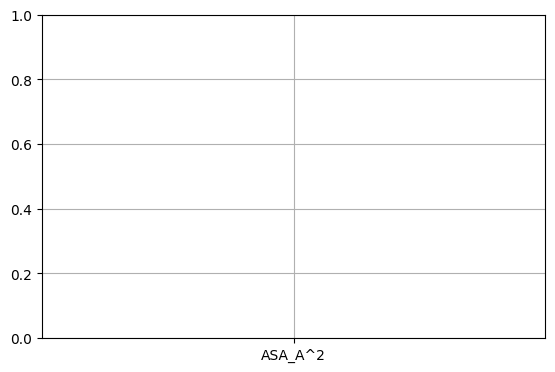

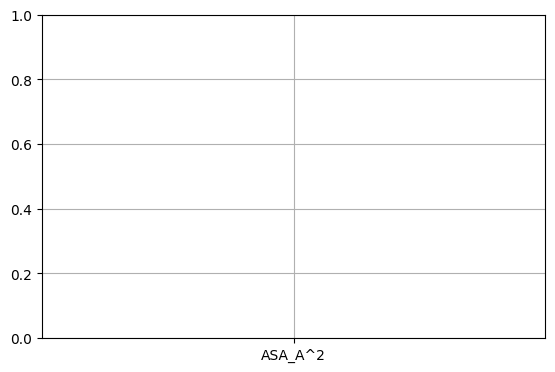

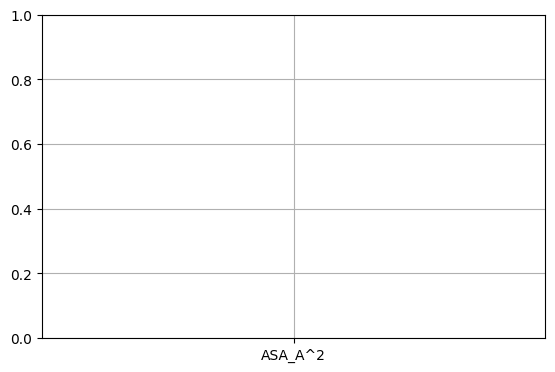

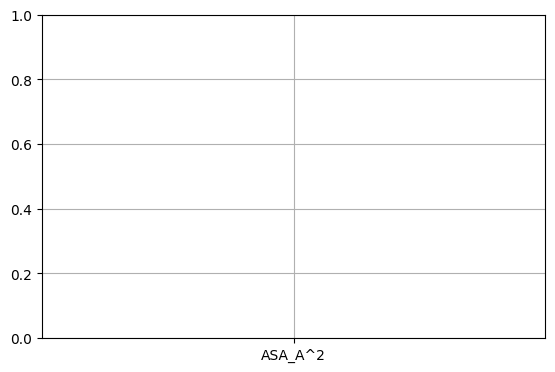

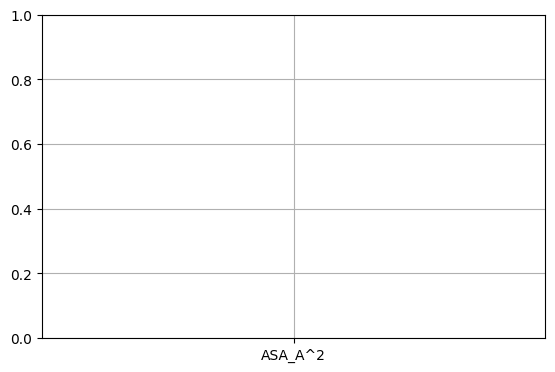

In [11]:

# Part 7 — Pore analysis (PA-*.csv): summary + generic plot
import glob

pa_paths = sorted(glob.glob(os.path.join(DATA_DIR, "PA-*.csv")))

for p in pa_paths:
    name = os.path.basename(p)
    try:
        df = pd.read_csv(p)
        print(f"=== {name} : summary ===")
        display(df.describe(include="all").T)
        cols = list(df.columns)
        if len(cols) >= 2:
            x = df[cols[0]].values
            y = df[cols[1]].values
            plt.figure()
            plt.plot(x, y, marker="o", linestyle="-")
            plt.xlabel(cols[0])
            plt.ylabel(cols[1])
            plt.title(f"{name} — {cols[1]} vs {cols[0]}")
            plt.show()
    except Exception as e:
        print(f"Failed to parse {name}: {e}")


In [12]:

# Part 8 — Ranking & conclusions (combine selectivity at 1 bar and WC metric)
if HAVE_PYIAST and "iast_df" in globals():
    iast_1bar = iast_df[iast_df["P_total_bar"]==1.0].copy()
    if "wc_df" in globals():
        summary = pd.merge(iast_1bar, wc_df, on="material", how="outer")
    else:
        summary = iast_1bar.copy()

    for col in ["S_CO2_over_N2", "WC_CO2_approx"]:
        if col in summary.columns:
            v = summary[col].astype(float)
            vmin, vmax = np.nanmin(v), np.nanmax(v)
            if vmax - vmin > 1e-12:
                summary[col+"_norm"] = (v - vmin) / (vmax - vmin)
            else:
                summary[col+"_norm"] = np.nan

    norm_cols = [c for c in ["S_CO2_over_N2_norm","WC_CO2_approx_norm"] if c in summary.columns]
    if norm_cols:
        summary["score"] = summary[norm_cols].mean(axis=1)
        summary = summary.sort_values("score", ascending=False)

    summary.reset_index(drop=True, inplace=True)
    summary
else:
    print("IAST results not available; install pyiast and rerun Parts 4–8.")


IAST results not available; install pyiast and rerun Parts 4–8.



## Appendix — Reproducibility notes

- **Units**: the loader attempts to detect pressure units from column names; if uncertain, it assumes **bar**.
- **Henry's coefficient**: estimated from a linear fit in the lowest-pressure region (<= 0.05 bar by default).
- **Model fitting**: we try Langmuir first, then Dual-Site Langmuir if the RMSE is poor relative to the data span.
- **IAST**: performed with `pyiast.iast` using fitted models. Results depend on model quality.
- **Working capacity**: approximated from pure-component model loadings at partial pressures (fast proxy). For rigorous mixture loadings, adapt to `pyiast` functions that return component loadings at spreading-pressure equilibrium.
- **Pore analysis (PA)**: format-agnostic summaries & first-two-columns plot; adapt axes labels if your PA files use specific conventions.
